In [1]:
# Importing libraries for data handling, image processing, and deep learning
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
# Defining paths for the dataset, data folder, example image, and corresponding mask
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
data_folder = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
eg_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809'
eg_img = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif'
eg_mask = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'


In [3]:
class BrainDataset(Dataset):
    def __init__(self, path, transform=None):
        """
        Custom Dataset class for loading brain MRI images and their corresponding masks.
        
        Args:
            path (str): Path to the directory containing patient folders with images and masks.
            transform (albumentations.Compose, optional): Transformation pipeline to apply to images and masks.
        """
        self.transform = transform
        self.images, self.masks = [], []

        # Exclude 'data.csv' and 'README.md' from patient directories
        self.patients = [file for file in os.listdir(path) if file not in ['data.csv', 'README.md']]

        # Collect all images and masks from the valid patient directories
        for patient in self.patients:
            patient_path = os.path.join(path, patient)
            if os.path.isdir(patient_path):
                for file in os.listdir(patient_path):
                    if "mask" in file.lower():  # Identify mask files
                        self.masks.append(os.path.join(patient_path, file))
                    else:  # Identify image files
                        self.images.append(os.path.join(patient_path, file))
        
        # Ensure images and masks are sorted to maintain correct pairing
        self.images = sorted(self.images)
        self.masks = sorted(self.masks)

    def __len__(self):
        # Returns the total number of images in the dataset
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Fetch an image and its corresponding mask by index.

        Args:
            idx (int): Index of the image-mask pair.

        Returns:
            tuple: (image, mask) where image is normalized and transformed.
        """
        # Load and preprocess image and mask
        image = cv2.imread(self.images[idx])
        image = np.array(image) / 255.0  # Normalize image to [0, 1]
        mask = cv2.imread(self.masks[idx], 0)  # Load mask in grayscale
        mask = np.array(mask) / 255.0  # Normalize mask to [0, 1]
        
        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert image to PyTorch tensor and channel-first format
        image = image.transpose((2, 0, 1))  # HWC -> CHW
        image = torch.from_numpy(image).float()
        
        # Convert mask to PyTorch tensor with a channel dimension
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        mask = torch.from_numpy(mask).float()
        
        return image, mask


In [4]:
import albumentations as A  # Image augmentations

# Define train and test transformations
train_transform = A.Compose([
    A.Resize(width=256, height=256, p=1.0),  # Resize images to 256x256
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),  # Random vertical flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  # Random shift, scale, and slight rotation
])

test_transform = A.Compose([
    A.Resize(width=256, height=256, p=1.0),  # Resize images to 256x256
])

# Step 1: Load the entire dataset without transformations
full_dataset = BrainDataset(path=data_folder, transform=None)

# Step 2: Split the dataset into training (80%) and testing (20%) subsets
train_size = int(0.8 * len(full_dataset))  # Calculate training size
test_size = len(full_dataset) - train_size  # Calculate testing size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 3: Assign transformations to the train and test datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Step 4: Create DataLoaders for batching and efficient data loading
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)  # Training DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)  # Testing DataLoader

# Step 5: Fetch a batch from the training loader for verification
images, masks = next(iter(train_loader))
print(images.shape)  # Expected: (batch_size, 3, 256, 256) for color images
print(masks.shape)   # Expected: (batch_size, 1, 256, 256) for masks


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


In [5]:
import torch
import torch.nn as nn

class convblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        """
        A convolutional block with Conv2D -> BatchNorm2D -> ReLU activation.
        """
        super(convblock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-4)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

class stackEncoder(nn.Module):
    def __init__(self, channel1, channel2, kernel_size=3, padding=1):
        """
        An encoder block with two convolutional layers followed by max pooling.
        """
        super(stackEncoder, self).__init__()
        self.block = nn.Sequential(
            convblock(channel1, channel2, kernel_size, padding),
            convblock(channel2, channel2, kernel_size, padding)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        fordecoder = self.block(x)  # Output for skip connection
        normal = self.maxpool(fordecoder)  # Downsampled output
        return fordecoder, normal

class stackDecoder(nn.Module):
    def __init__(self, big_channel, channel1, channel2, kernel_size=3, padding=1):
        """
        A decoder block with upsampling, skip connection, and two convolutional layers.
        """
        super(stackDecoder, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels=big_channel, out_channels=big_channel, kernel_size=2, stride=2)
        self.block = nn.Sequential(
            convblock(channel1 + big_channel, channel2, kernel_size, padding),
            convblock(channel2, channel2, kernel_size, padding)
        )

    def forward(self, x, dow_tensor):
        x = self.upsample(x)  # Upsample the input
        x = torch.cat([x, dow_tensor], dim=1)  # Concatenate skip connection
        x = self.block(x)  # Apply convolutional layers
        return x

class Unet(nn.Module):
    def __init__(self):
        """
        U-Net model implementation for image segmentation.
        """
        super(Unet, self).__init__()
        # Encoder blocks (downsampling)
        self.down1 = stackEncoder(3, 64)  # Output size: 128
        self.down2 = stackEncoder(64, 128)  # Output size: 64
        self.down3 = stackEncoder(128, 256)  # Output size: 32
        self.down4 = stackEncoder(256, 512)  # Output size: 16
        self.down5 = stackEncoder(512, 1024)  # Output size: 8

        # Center block
        self.center = convblock(1024, 1024)  # Output size: 8

        # Decoder blocks (upsampling)
        self.up5 = stackDecoder(1024, 1024, 512)  # Output size: 16
        self.up4 = stackDecoder(512, 512, 256)  # Output size: 32
        self.up3 = stackDecoder(256, 256, 128)  # Output size: 64
        self.up2 = stackDecoder(128, 128, 64)  # Output size: 128
        self.up1 = stackDecoder(64, 64, 32)  # Output size: 256

        # Final convolutional layer to produce the segmentation map
        self.conv = nn.Conv2d(32, 1, 1, bias=True)

    def forward(self, x):
        # Pass through the encoder
        down1, out = self.down1(x)
        down2, out = self.down2(out)
        down3, out = self.down3(out)
        down4, out = self.down4(out)
        down5, out = self.down5(out)

        # Pass through the center block
        out = self.center(out)

        # Pass through the decoder
        up5 = self.up5(out, down5)
        up4 = self.up4(up5, down4)
        up3 = self.up3(up4, down3)
        up2 = self.up2(up3, down2)
        up1 = self.up1(up2, down1)

        # Generate the output segmentation map
        out = self.conv(up1)
        out = torch.sigmoid(out)  # Sigmoid activation for binary segmentation
        
        return out


In [23]:
# Function to calculate the Dice coefficient metric between prediction and ground truth
def dice_coef_metric(pred, label):
    """
    Computes the Dice coefficient, a measure of overlap between prediction and label.

    Args:
        pred (torch.Tensor): Predicted segmentation map.
        label (torch.Tensor): Ground truth segmentation map.

    Returns:
        float: Dice coefficient score.
    """
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:  # Handle edge case where both are empty
        return 1.0
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth
def dice_coef_loss(pred, label):
    """
    Computes the Dice loss, used to optimize segmentation tasks.

    Args:
        pred (torch.Tensor): Predicted segmentation map.
        label (torch.Tensor): Ground truth segmentation map.

    Returns:
        float: Dice loss value.
    """
    smooth = 1.0  # Smoothing factor to avoid division by zero
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss
def bce_dice_loss(pred, label):
    """
    Combines Binary Cross Entropy (BCE) loss and Dice loss for better optimization.

    Args:
        pred (torch.Tensor): Predicted segmentation map.
        label (torch.Tensor): Ground truth segmentation map.

    Returns:
        float: Combined BCE and Dice loss.
    """
    dice_loss = dice_coef_loss(pred, label)  # Calculate Dice loss
    bce_loss = nn.BCELoss()(pred, label)  # Calculate Binary Cross Entropy loss
    return dice_loss + bce_loss


In [21]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize the U-Net model and move it to the selected device
unet = Unet().to(device)

# Initialize the optimizer with Adam and learning rate
optimizer = Adam(unet.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

# Lists to store metrics for plotting
train_losses = []
train_dice_scores = []
test_losses = []
test_dice_scores = []

# Number of epochs for training
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    unet.train()  # Set the model to training mode
    train_loss = 0
    train_dice = 0
    
    # Training phase
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to the appropriate device
        data, target = data.to(device).float(), target.to(device).float()

        # Forward pass
        output = unet(data)

        # Calculate the loss (BCE + Dice)
        loss = bce_dice_loss(output, target)
        train_loss += loss.item() 
        
        # Calculate Dice coefficient for the batch
        out_cut = (output.data.cpu().numpy() >= 0.5).astype(np.float32)
        dice_value = dice_coef_metric(out_cut, target.data.cpu().numpy())
        train_dice += dice_value
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss and Dice score for the epoch
    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    train_losses.append(avg_train_loss)
    train_dice_scores.append(avg_train_dice)

    # Testing phase
    unet.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_dice = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to the appropriate device
            data, target = data.to(device).float(), target.to(device).float()

            # Forward pass
            output = unet(data)

            # Calculate the loss (BCE + Dice)
            loss = bce_dice_loss(output, target)
            test_loss += loss.item()

            # Calculate Dice coefficient for the batch
            out_cut = (output.data.cpu().numpy() >= 0.5).astype(np.float32)
            dice_value = dice_coef_metric(out_cut, target.data.cpu().numpy())
            test_dice += dice_value

    # Calculate average testing loss and Dice score for the epoch
    avg_test_loss = test_loss / len(test_loader)
    avg_test_dice = test_dice / len(test_loader)
    test_losses.append(avg_test_loss)
    test_dice_scores.append(avg_test_dice)

    # Adjust the learning rate based on validation Dice score
    scheduler.step(avg_test_dice)

    # Logging metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Train Dice: {avg_train_dice:.8f}, "
          f"Test Loss: {avg_test_loss:.8f}, Test Dice: {avg_test_dice:.8f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save the best model based on validation Dice score
    if epoch == 0 or avg_test_dice > max(test_dice_scores[:-1], default=0):
        torch.save(unet.state_dict(), "/kaggle/working/best_model.pth")
        print(f"Best model saved at epoch {epoch+1} with Dice score: {avg_test_dice:.8f}")


cuda
Epoch 1/50, Train Loss: 1.06713915, Train Dice: 0.37475920, Test Loss: 0.78042281, Test Dice: 0.46565167, LR: 0.001000
Best model saved at epoch 1 with Dice score: 0.46565167
Epoch 2/50, Train Loss: 0.66057462, Train Dice: 0.47255547, Test Loss: 0.69334294, Test Dice: 0.38544982, LR: 0.001000
Epoch 3/50, Train Loss: 0.55584190, Train Dice: 0.51213631, Test Loss: 0.71595173, Test Dice: 0.35923641, LR: 0.001000
Epoch 4/50, Train Loss: 0.51573118, Train Dice: 0.54476711, Test Loss: 0.48088642, Test Dice: 0.59017542, LR: 0.001000
Best model saved at epoch 4 with Dice score: 0.59017542
Epoch 5/50, Train Loss: 0.49768073, Train Dice: 0.55949560, Test Loss: 0.50128823, Test Dice: 0.57115116, LR: 0.001000
Epoch 6/50, Train Loss: 0.50064754, Train Dice: 0.55504556, Test Loss: 0.44215826, Test Dice: 0.62401193, LR: 0.001000
Best model saved at epoch 6 with Dice score: 0.62401193
Epoch 7/50, Train Loss: 0.48015060, Train Dice: 0.57209833, Test Loss: 0.45915605, Test Dice: 0.60516642, LR: 0.0

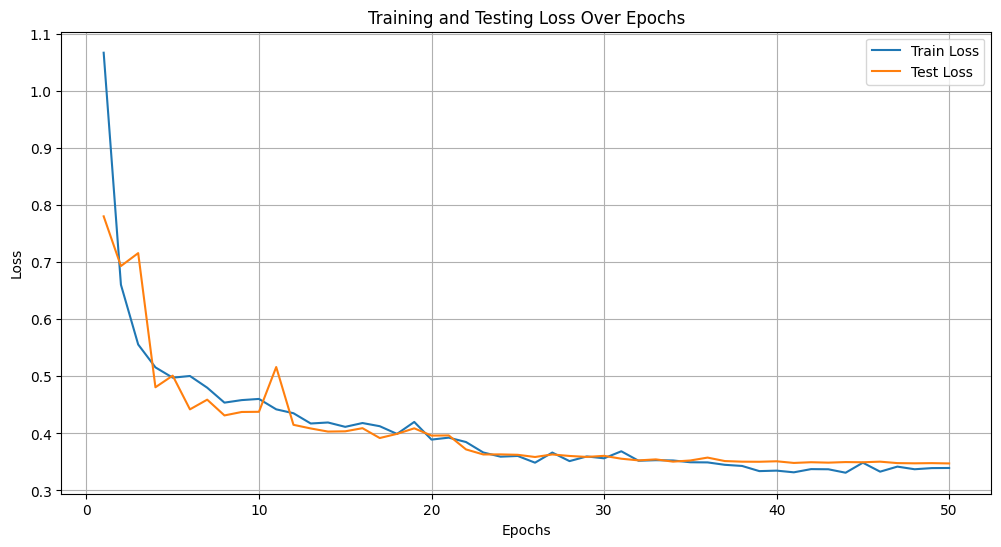

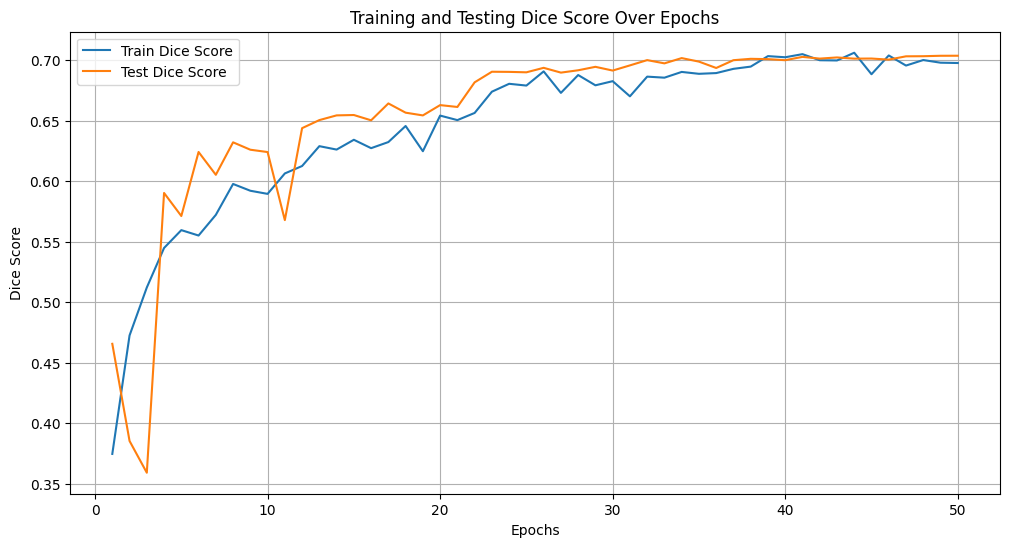

In [22]:
import matplotlib.pyplot as plt

# Plot training and testing losses
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")  # Plot training loss
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")  # Plot testing loss
plt.xlabel("Epochs")  # Label for the x-axis
plt.ylabel("Loss")  # Label for the y-axis
plt.title("Training and Testing Loss Over Epochs")  # Plot title
plt.legend()  # Add legend
plt.grid()  # Add grid lines
plt.show()  # Display the plot

# Plot training and testing Dice scores
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(range(1, num_epochs + 1), train_dice_scores, label="Train Dice Score")  # Plot training Dice score
plt.plot(range(1, num_epochs + 1), test_dice_scores, label="Test Dice Score")  # Plot testing Dice score
plt.xlabel("Epochs")  # Label for the x-axis
plt.ylabel("Dice Score")  # Label for the y-axis
plt.title("Training and Testing Dice Score Over Epochs")  # Plot title
plt.legend()  # Add legend
plt.grid()  # Add grid lines
plt.show()  # Display the plot


Using device: cpu


/tmp/ipykernel_24/3798137725.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


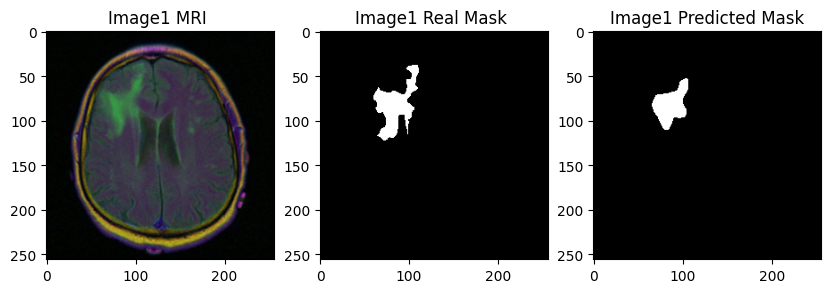

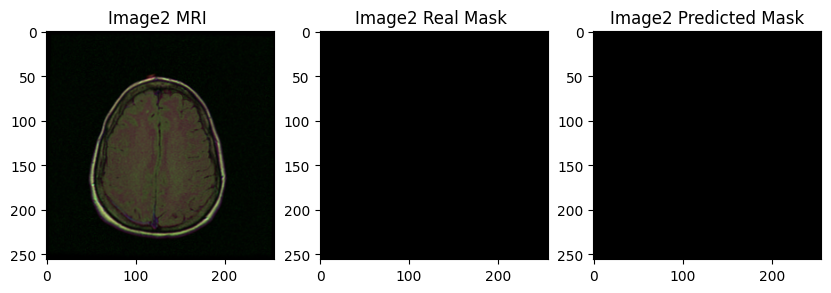

In [9]:
import cv2
import torch
import matplotlib.pyplot as plt
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

def load_and_transform(image_path, mask_path, transform):
    """
    Load an image and its corresponding mask, apply transformations, and return the processed tensors.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the ground truth mask.
        transform (albumentations.Compose): Transformation pipeline to apply.

    Returns:
        tuple: Original image (RGB), original mask (RGB), and transformed image tensor.
    """
    # Read image and mask
    image = cv2.imread(image_path)  # Read image in BGR format
    mask = cv2.imread(mask_path)  # Read mask in BGR format (for visualization)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Apply transformations to the image
    transformed = transform(image=image)
    image_tensor = transformed["image"]

    return image, mask, image_tensor

def plot_results(image_rgb, mask_rgb, pred_mask, title_prefix):
    """
    Plot the original image, ground truth mask, and predicted mask.

    Args:
        image_rgb (ndarray): Original input image in RGB.
        mask_rgb (ndarray): Ground truth mask in RGB.
        pred_mask (ndarray): Predicted binary mask.
        title_prefix (str): Title prefix for the plot.
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix} MRI")
    plt.imshow(image_rgb)  # Display the original image

    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix} Real Mask")
    plt.imshow(mask_rgb)  # Display the ground truth mask

    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix} Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')  # Display the predicted mask

    plt.show()

# Define image and mask paths with titles
paths = [
    {
        "image": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif",
        "mask": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif",
        "title": "Image1"
    },
    {
        "image": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26.tif",
        "mask": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26_mask.tif",
        "title": "Image2"
    }
]

# Define transformations
transform = Compose([
    Resize(256, 256),  # Resize images to 256x256
    Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),  # Normalize pixel values to [0,1]
    ToTensorV2()  # Convert to PyTorch tensor
])

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize and load the U-Net model
model = Unet().to(device)
model.eval()

# Load the model checkpoint and handle potential "module." prefix in DataParallel checkpoints
checkpoint_path = "/kaggle/input/unet/pytorch/default/1/best_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Adjust state dictionary keys if DataParallel was used during training
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = k[len("module."):] if k.startswith("module.") else k
    new_state_dict[name] = v

# Load adjusted state dictionary into the model
model.load_state_dict(new_state_dict, strict=True)

# Process each image and its mask
for path in paths:
    # Load and transform the image and mask
    image, mask, image_tensor = load_and_transform(path["image"], path["mask"], transform)

    # Prepare input for the model
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Generate predictions
    with torch.no_grad():
        output = model(image_tensor.float())
        output_mask = (output >= 0.5).float()  # Threshold the output to binary mask

    # Convert predictions to numpy array
    predicted_mask_np = output_mask.squeeze().cpu().numpy()

    # Resize the ground truth mask for comparison
    mask_rgb_resized = cv2.resize(mask, (256, 256))

    # Plot and compare results
    plot_results(image, mask_rgb_resized, predicted_mask_np, path["title"])
